In [110]:
import numpy as np
import scipy
from scipy.interpolate import BSpline
from scipy.interpolate import _bspl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 200
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

from colors_labels import *
import bao_utils

In [2]:
import Corrfunc
from Corrfunc.io import read_lognormal_catalog, read_fortran_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.DD import DD
from Corrfunc.theory.xi import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import qq_analytic
from Corrfunc.bases import spline, bao

In [3]:
colors = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']*6

In [43]:
plot_dir = '../plots/plots_2020-12-23'

In [4]:
def distance(pointa, pointb):
    return np.linalg.norm(np.array(pointa)-np.array(pointb))

In [5]:
def circle(x, r):
    return np.sqrt(r**2 - x**2)

In [6]:
def rand_between(mymin, mymax, n=1):
    return np.random.rand(n)*(mymax-mymin) + mymin

In [111]:
def bases_panel(ax, bases, colors, rsep, rcolor, bases_ordered=None, rescale_by=None, xlim=(0, 140), ylim=(0,1)):

    bases = bases.copy()
    r = bases[:,0]
    nbases = len(bases[0])-1
    
    if bases_ordered is None:
        bases_ordered = np.arange(nbases)
    
    for i in bases_ordered:
        base = bases[:,i+1]
        if rescale_by is not None:
            base *= rescale_by[i]
        ax.plot(r, base, color=colors[i], lw=2)
        
        # plot intersection points with rsep line
        idx = (np.abs(r - rsep)).argmin()
        base_val = base[idx]
        if base_val!=0:
            ax.scatter(rsep, base_val, color=colors[i], marker='d', s=70,
                       edgecolor=rcolor, zorder=1000)
    
    ax.axvline(rsep, color=rcolor, alpha=0.3, ls='--', lw=3, zorder=0)
    ax.text(rsep-14, 0.75*ylim[1], r"$r_{nn'}$", fontsize=20)
        
    ax.axhline(0, color='grey', lw=0.8, zorder=0)
        
    ax.set_ylabel('$f_k(r)$ (arbitrary units)')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

In [8]:
def results_panel(ax, bases, colors, amps, r_fine, xi, bases_ordered=None, xlim=(0, 140), ylim=None):

    bases = bases.copy()
    r = bases[:,0]
    nbases = len(bases[0])-1
    
    if bases_ordered is None:
        bases_ordered = np.arange(nbases)
        
    for i in bases_ordered:
        base = bases[:,i+1]
        base *= amps[i]
        ax.plot(r, base, color=colors[i], lw=2)
        
    ax.plot(r_fine, xi, color='k', lw=3)
        
    ax.axhline(0, color='grey', lw=0.8, zorder=0)
    
    ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set_ylabel(r'$a_k \, f_k(r), \,\,\, \xi(r)$')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    #ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    plt.locator_params(axis='y', nbins=3)
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

In [123]:
def data_panel(ax, data, zslice=(0,300), xlim=(0, 140), ylim=(0,70)):
    
    # settings
    marker = 'o'
    size=5
    col='blue'
    col_points = 'grey'
    alpha_points = 0.7
    n = 200
    circle_alpha = 0.3
    highlight_radius = 3

    # two main galaxies
    gal_main = [0, 0]
    ax.scatter(gal_main[0], gal_main[1], marker=marker, c=col_points, s=size, alpha=alpha_points, zorder=1000, lw=0)
    highlight = plt.Circle(gal_main, radius=highlight_radius, fill=None, color=col, lw=2)
    ax.add_artist(highlight)

    gal = [97, 40]
    ax.scatter(gal[0], gal[1], marker=marker, c=col_points, s=size, alpha=alpha_points, zorder=1000, lw=0)
    highlight = plt.Circle(gal, radius=highlight_radius, fill=None, color=col, lw=2)
    ax.add_artist(highlight)

    # circles and lines
    r = distance(gal_main, gal)
    x = np.linspace(rmin-2, rmax, 30000)
    circ = circle(x, r)
    ax.plot(np.concatenate((x, [r])), np.concatenate((circ, [0])), color=col, lw=3, zorder=0, alpha=circle_alpha)
    ax.plot(x, -circ, color=col, lw=3, zorder=0, alpha=circle_alpha)
    ax.plot([gal_main[0], gal[0]], [gal_main[1], gal[1]], color=col, linestyle='-', linewidth=2)
    ax.text(0.5*(gal_main[0] + gal[0]), 0.5*(gal_main[1] + gal[1])+7, r"$r_{nn'}$", fontsize=20)

    # all points
    in_slice = np.argwhere((zslice[0] <= data[2]) & (data[2] < zslice[1]))
    xdata = data[0][in_slice]
    ydata = data[1][in_slice]
    ax.scatter(xdata, ydata, marker=marker, c=col_points, s=size, alpha=alpha_points, lw=0)

    ax.set_ylabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set(xlim=xlim, ylim=ylim, aspect=1)
    ax.set(adjustable="box")
    
    return r, col

## load lognormal data

In [10]:
realization = 0
boxsize = 750
cat_tag = f'_L{boxsize}_n2e-4_z057_patchy'
cat_fn = f'../catalogs/lognormal/cat{cat_tag}_lognormal_rlz{realization}.bin'

In [11]:
x, y, z = read_fortran_catalog(cat_fn)
data = [x, y, z]
boxsize = 750.0
nd = len(x)
print("Number of data points:",nd)

Number of data points: 85827


In [12]:
# parameters for both
rmin = 0.0
rmax = 140.0
ncont = 2000
r_fine = np.linspace(rmin, rmax, ncont)
nmubins = 1
mumax = 1.0
periodic = True
nthreads = 1
proj_type = 'generalr'
volume = boxsize**3

## spline basis

In [13]:
nprojbins_spline = 16
r_edges_spline = np.linspace(rmin, rmax, nprojbins_spline+1)

In [15]:
kwargs_spline = {'order': 3} # 3: cubic spline
projfn_spline = '../tables/cubic_spline.dat'
spline.write_bases(rmin, rmax, nprojbins_spline, projfn_spline, ncont=ncont, **kwargs_spline)

'../tables/cubic_spline.dat'

In [17]:
dd_res_spline, dd_proj_spline, _ = DDsmu(1, nthreads, r_edges_spline, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, 
                           nprojbins=nprojbins_spline, projfn=projfn_spline)

In [20]:
rr_ana_spline, qq_ana_spline = qq_analytic(rmin, rmax, nd, volume, nprojbins_spline, proj_type, 
                                           projfn=projfn_spline, rbins=r_edges_spline)
numerator_spline = dd_proj_spline - rr_ana_spline
amps_ana_spline = np.linalg.solve(qq_ana_spline, numerator_spline)
xi_ana_spline = evaluate_xi(amps_ana_spline, r_fine, proj_type, projfn=projfn_spline, rbins=r_edges_spline)

Evaluating qq_analytic (Corrfunc/utils.py)
Evaluating xi (Corrfunc/utils.py)


/Users/ksf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


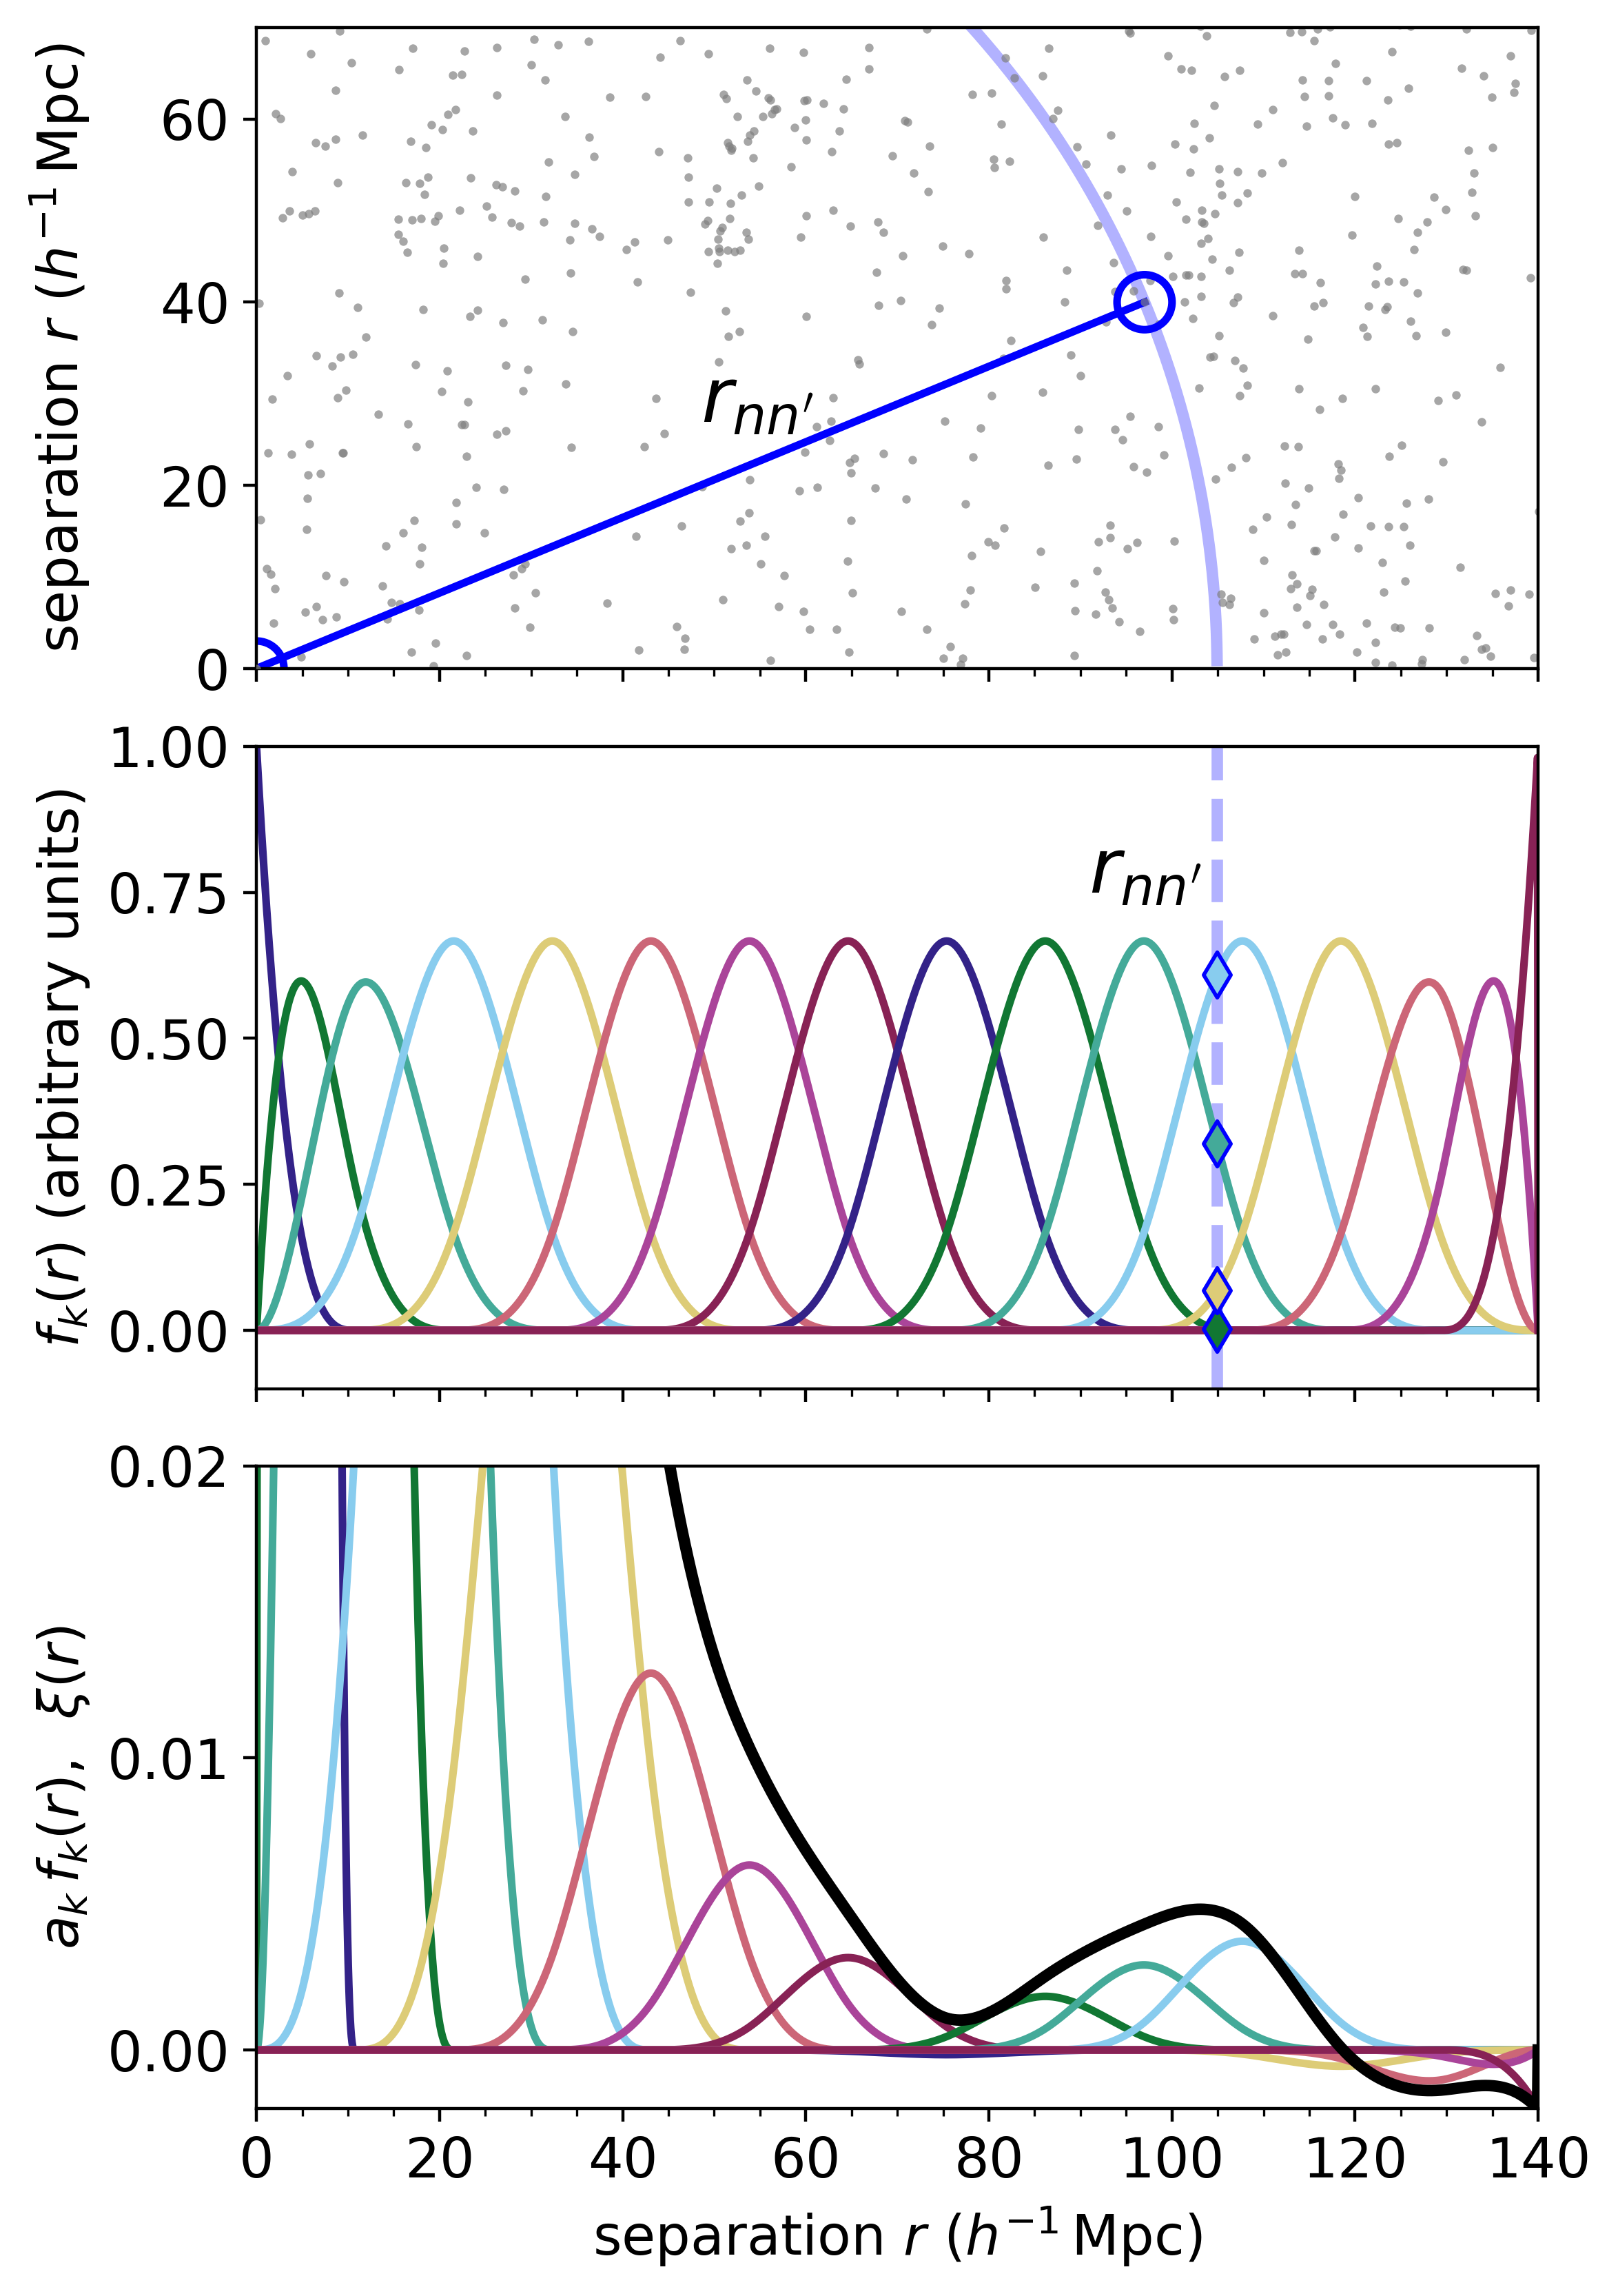

In [124]:
fig, axarr = plt.subplots(3,1, figsize=(6,10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
plt.subplots_adjust(hspace=0.12)

bases_spline = np.loadtxt(projfn_spline)

rsep, rcolor = data_panel(axarr[0], data)
bases_panel(axarr[1], bases_spline, colors, rsep, rcolor, ylim=(-0.1, 1))
results_panel(axarr[2], bases_spline, colors, amps_ana_spline, r_fine, xi_ana_spline, ylim=(-0.002, 0.02))
fig.align_ylabels(axarr)

save_fn = 'schematic_spline.png'
plt.savefig(f'{plot_dir}/{save_fn}', bbox_inches='tight')

## BAO basis

In [62]:
rmin_bao=0.01 #issues with analytic solution for rmin=0
rmax_bao=140.0

In [95]:
cat_tag = f'_L{boxsize}_n2e-4_z057_patchy'

proj = 'baoiter'
cosmo_name = 'b17'
cf_tag = f"_{proj}_cosmo{cosmo_name}_convtest"
redshift = 0.57
bias = 2.0
dalpha = 0.001
alpha_model_start = 0.95

projfn_bao = f"../tables/bases{cat_tag}{cf_tag}_r{rmin_bao}-{rmax_bao}_z{redshift}_bias{bias}.dat"
cosmo = bao_utils.get_cosmo(cosmo_name)
kwargs_bao = {'cosmo_base':cosmo, 'redshift':redshift, 'dalpha':dalpha, 'alpha_model':alpha_model_start, 'bias':bias}
nprojbins_bao, _ = bao.write_bases(rmin_bao, rmax_bao, projfn_bao, **kwargs_bao)
print(projfn_bao)

bases_bao = np.loadtxt(projfn_bao)

0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06] 0.8240000000000002 2.0328
bias: 2.0. dalpha: 0.001, alpha_model: 0.95
../tables/bases_L750.0_n2e-4_z057_patchy_baoiter_cosmob17_convtest_r0.01-140.0_z0.57_bias2.0.dat


In [96]:
ncont = 2000
r_edges_bao = np.linspace(rmin_bao, rmax_bao, nprojbins_bao+1)

In [97]:
proj_type = 'generalr'

In [98]:
dd_res_bao, dd_proj_bao, _ = DDsmu(1, nthreads, r_edges_bao, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, 
                           nprojbins=nprojbins_bao, projfn=projfn_bao)

In [99]:
volume = boxsize**3
rr_ana_bao, qq_ana_bao = qq_analytic(rmin_bao, rmax_bao, nd, volume, nprojbins_bao, proj_type, 
                                     projfn=projfn_bao, rbins=r_edges_bao)
numerator_bao = dd_proj_bao - rr_ana_bao
amps_ana_bao = np.linalg.solve(qq_ana_bao, numerator_bao)
xi_ana_bao = evaluate_xi(amps_ana_bao, r_fine, proj_type, projfn=projfn_bao, rbins=r_edges_bao)

Evaluating qq_analytic (Corrfunc/utils.py)
Evaluating xi (Corrfunc/utils.py)


/Users/ksf/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


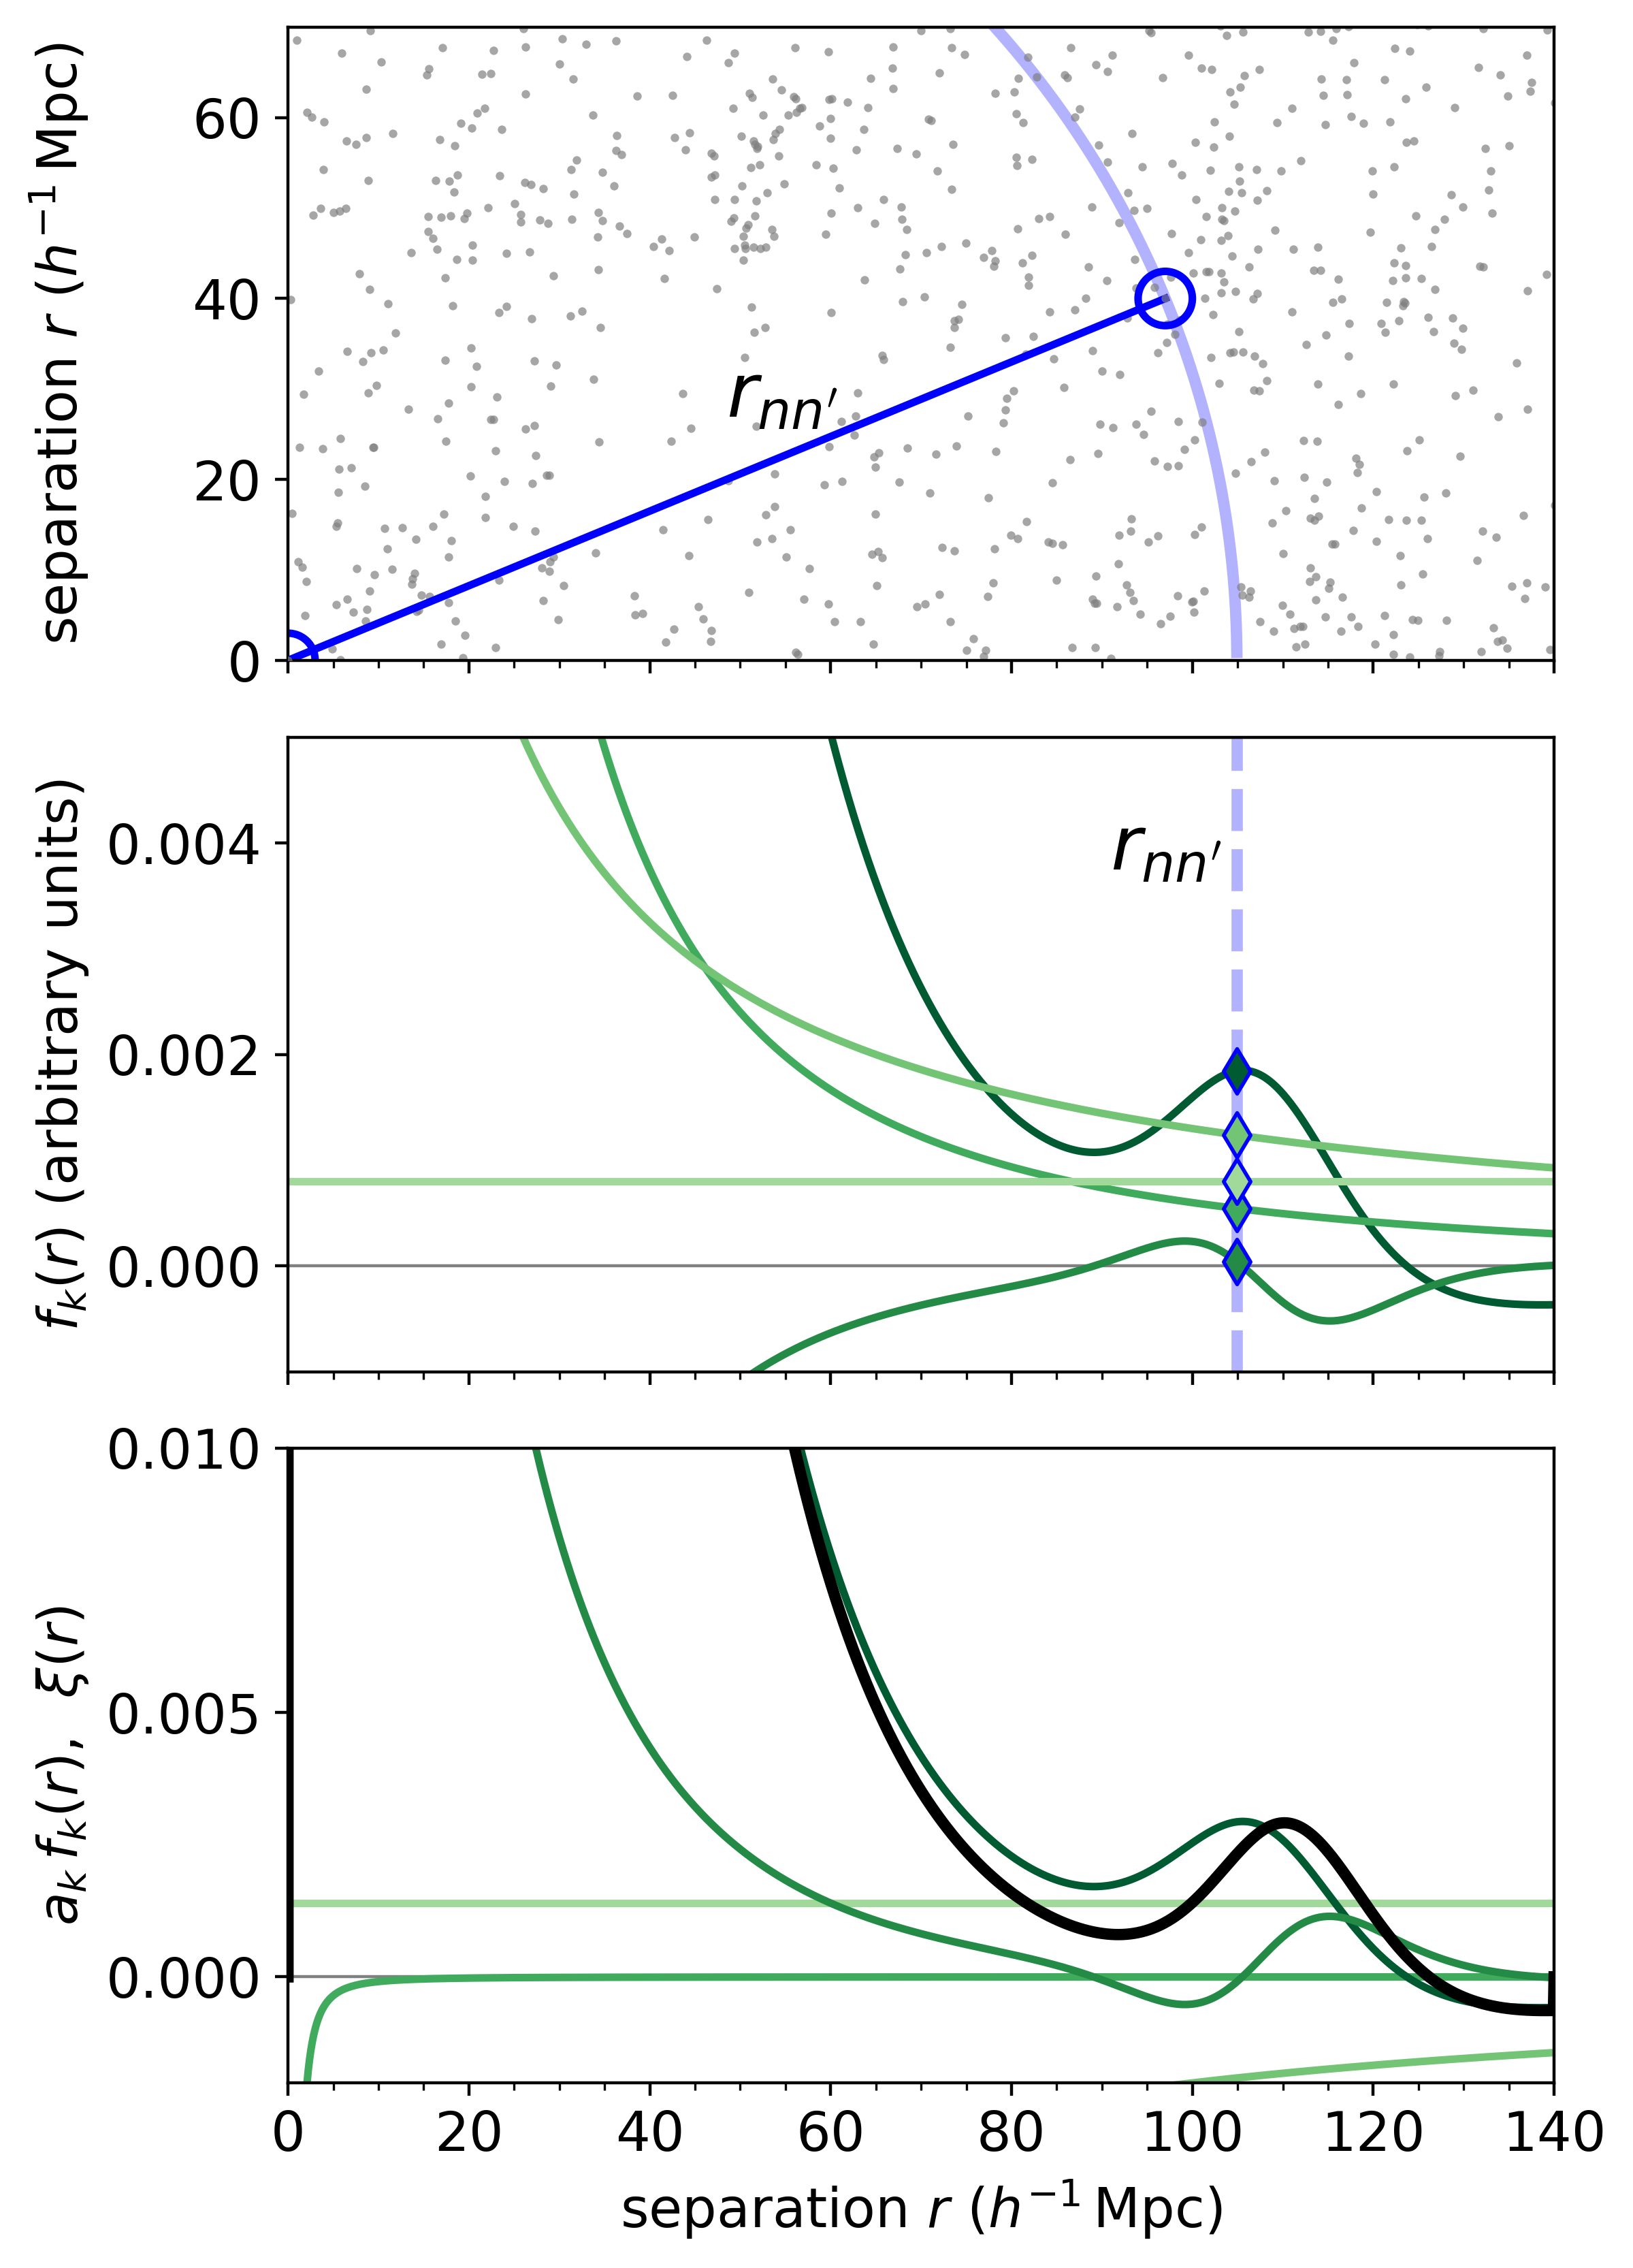

In [125]:
fig, axarr = plt.subplots(3,1, figsize=(6,10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
plt.subplots_adjust(wspace=0.1, hspace=0.12)

rescale_by = [6, 1.3, 0.8, 1, 30]
    
rsep, rcolor = data_panel(axarr[0], data, zslice=(0,400))
bases_panel(axarr[1], bases_bao, bao_base_colors, rsep, rcolor,
            bases_ordered=[3,4,0,1,2], rescale_by=rescale_by, ylim=(-0.001, 0.005))
results_panel(axarr[2], bases_bao, bao_base_colors, amps_ana_bao, r_fine, xi_ana_bao, ylim=(-0.002, 0.01))
fig.align_ylabels(axarr)

save_fn = 'schematic_bao.png'
plt.savefig(f'{plot_dir}/{save_fn}', bbox_inches='tight')